In [39]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm import tqdm
np.random.seed(1234)

# Individuals
* The base unit of an evolutionary algorithm (EA) is the individual.
* An individual represents a single solution to the problem we want to solve.
* Classic EAs often have binary individuals, where each gene is represented by a bit (0/1 value).

In [40]:
class Individual:

    def __init__(self, n: int):
        self.genes = np.random.randint(0, 2, (n,))
        self.fitness = -np.inf

    def __str__(self):
        return f'(Ind: {self.genes}, {self.fitness})'

    def __repr__(self):
        return str(self)

* Individual has binary genes and an integer fitness.
* A newly-initialized individual often has random genes.

In [41]:
ind = Individual(10)
ind

(Ind: [1 1 0 1 0 0 0 1 1 1], -inf)

# Objectives
* The objective function gives a value to our individual.
* The objective function can be designed so that it can **evaluate** the individual.
* The objective function value of an individual is often called the **fitness value** of that individual.
* The objective function does not need to be differentiable or continuous.

In [42]:
def onemax(i: Individual):
    return np.sum(i.genes)

* The OneMax function simply adds all the bits of the genotype of the individual.

In [43]:
ind.fitness = onemax(ind)
ind

(Ind: [1 1 0 1 0 0 0 1 1 1], 6)

* The optimal solution for OneMax is the individual that has the genotype of all 1s.

* To be more general, we often define an **evaluate** function, which evaluate the fitness value of an individual.

In [44]:
def evaluate(ind: Individual, objective):
    ind.fitness = objective(ind)

evaluate(ind, onemax)
ind

(Ind: [1 1 0 1 0 0 0 1 1 1], 6)

* Each time we evaluate the fitness value of an individual, we spend one evaluation function call.
* To be abstract from the exact runtime on specific hardware, we often use the **number of evaluations** as the computing cost/budget for EAs.

# (1+1) Evolutionary Algorithm ~~~ (1+1)-EA

1. Initialize a random individual of $n$ genes, i.e., a bitstring $x\in\{0;1\}^n$.
2. Repeat the following **mutation** step:
    1. Compute $x'$ by flipping each bit $x_i$ with probability $p$.
    2. Replace $x$ by $x'$ if $f(x')\geq f(x)$.

In [45]:
n = 20

In [46]:
parent = Individual(n)
evaluate(parent, onemax)
parent

(Ind: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0], 6)

In [47]:
def mutate(ind: Individual, mutation_rate=1.0/len(ind.genes)):
    new_genes = np.copy(ind.genes)
    for i in range(len(new_genes)):
        if np.random.rand() < mutation_rate:
            new_genes[i] = not ind.genes[i]
    child = Individual(len(ind.genes))
    child.genes = new_genes
    return child

* The **mutate** function create a **child/offspring** individual from a **parent** individual with the mutation probability of $p=\frac{1}{n}$.
* We scan through each gene in an individual.
* For each gene, we generate a random number $r\in (0,1)$.
* If $r < p$, we flip the gene value $0 \leftrightarrow 1$.

In [48]:
child = mutate(parent)
print("Parent :", parent)
print("Child  :", child)
print("Genes :", parent.genes == child.genes)

Parent : (Ind: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0], 6)
Child  : (Ind: [1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0], -inf)
Genes : [ True  True False  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True]


* Running this mutation function a few times.
* Each time, only one or two genes change because the mutation rate is set to $p=\frac{1}{n}$.

In [49]:
child = mutate(parent)
print("Parent :", parent)
print("Child  :", child)
print("Genes :", parent.genes == child.genes)

Parent : (Ind: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0], 6)
Child  : (Ind: [1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0], -inf)
Genes : [ True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True]


In [50]:
child = mutate(parent)
print("Parent :", parent)
print("Child  :", child)
print("Genes :", parent.genes == child.genes)

Parent : (Ind: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0], 6)
Child  : (Ind: [1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0], -inf)
Genes : [ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


* Each time, we replace the parent individual $x$ by the child individual $x'$ if the fitness of the offspring is better, i.e., $f(x')\geq f(x)$.

In [51]:
evaluate(child, onemax)
print(parent.fitness)
print(child.fitness)
if child.fitness >= parent.fitness:
    parent = child
parent.fitness

6
7


np.int64(7)

* We simply run this mutation step over and over until we reach the solution we want or the certain **termination criterion** is met (e.g., the **maximum number of evaluations** are all spent).
* Let's just run for a few iterations.

In [52]:
parent = Individual(n)
for i in range(20):
    child = mutate(parent)
    evaluate(child, onemax)
    if child.fitness >= parent.fitness:
        parent = child
    # print(i, " ", parent.fitness)

print(parent.fitness, " / ", n)

19  /  20


* Let's code the (1+1)-EA.

In [53]:
def one_plus_one(ind_length: int, num_generations: int, objective):
    fits = np.zeros(num_generations)
    parent = Individual(ind_length)
    evaluate(parent, objective)

    for i in tqdm(range(len(fits))):
        child = mutate(parent)
        evaluate(child, objective)

        if child.fitness >= parent.fitness:
            parent = child

        fits[i] = parent.fitness
    return fits

* Since EAs are stochastic algorithm, it's difficult to guarantee their exact computational complexity.
* A common metric is the **expected number of generations** to each the optimal solution.
* The worst-case for a binary (1+1)-EA to converge is $O(n^n)$, but we often don't need to run that long to see convergence.
* For OneMax, the expected runtime for (1+1)-EA has been proven to be $O(n\log{n})$ when the mutation rate is $p=\frac{1}{n}$.
https://core.ac.uk/download/pdf/82100186.pdf

In [54]:
n = 50
fits = one_plus_one(n, int(np.round(n * np.log(n))), onemax)
print(fits[-1])

100%|██████████| 196/196 [00:00<00:00, 19156.54it/s]

45.0


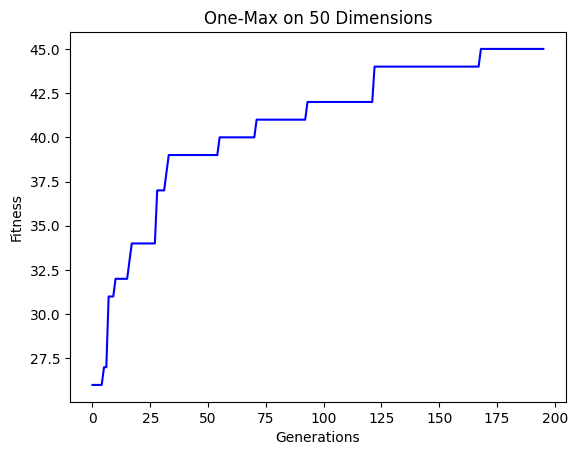

In [55]:
plt.plot(fits, 'b')
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions");

In [56]:
n = 50
fits = one_plus_one(n, int(np.round(n * np.log(n)))*10, onemax)
print(fits[-1])

100%|██████████| 1960/1960 [00:00<00:00, 19990.70it/s]

49.0


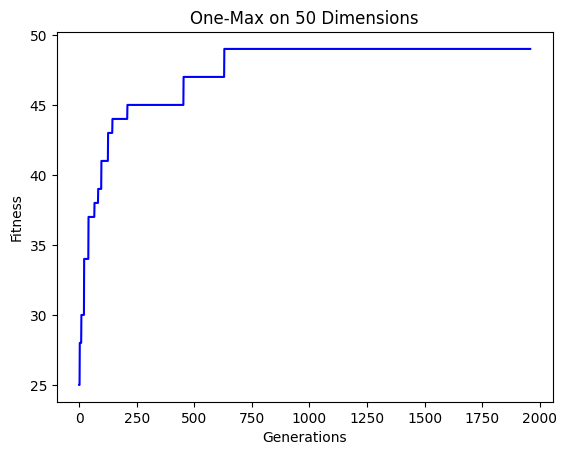

In [57]:
plt.plot(fits, 'b')
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions");

* The **Leading Ones** problem is another benchmark function for EAs.
* The Leading Ones function counts the number of 1-bits from left to right, stopping when the first 0-bit is found.

<div style='text-align: center;'>
$f(x) = \sum_{i=1}^n\prod_{j=1}^i x_j$
    </div>

In [58]:
def leading_ones(ind: Individual):
    f = 0
    for i in range(len(ind.genes)):
        if not ind.genes[i]:
            f = i
            break
        if i == len(ind.genes) - 1:
            f = len(ind.genes)
    return f
print(ind)
leading_ones(ind)

(Ind: [1 1 0 1 0 0 0 1 1 1], 6)


2

**Question**: What is the expected runtime of (1+1)-EA on the Leading Ones problem?

# (1+λ) Evolutionary Algorithm - (1+λ)-EA
* We made a small change to the (1+1)-EA: instead of generating one offspring individual each iteration (generation), we generate λ offspring individuals.
* These λ individuals can be called a **population**, and λ is the **population size**.

* For (1+λ)-EA, beside the mutation rate, the population size is another control parameter of the algorithm (i.e., hyperparameter).
* The expected runtime for (1+λ)-EA on OneMax is upper bounded by $O(n\log\logλ/\logλ)$ when λ is larger than $O(\log n\log\log n/\log\log\log n)$.
https://www.sciencedirect.com/science/article/pii/S0304397514002060

* We modify one_plus_one function to create the one_plus_lambda function.
* We keep track of the best offspring individual to compare it with the parent individual in the next generation.

In [59]:
def one_plus_lambda(ind_length: int, num_generations: int, objective, 𝜆: int):
    fits = np.zeros(num_generations)
    parent = Individual(ind_length)
    evaluate(parent, objective)

    for i in tqdm(range(len(fits))):
        population = [parent,]
        best = 0
        for j in range(1, 𝜆):
            population.append(mutate(parent))
            evaluate(population[j], objective)
            if population[j].fitness > population[best].fitness:
                best = j
        if population[best].fitness >= parent.fitness:
            parent = population[best]
        fits[i] = parent.fitness
    return fits

In [60]:
n = 100
𝜆 = int(round(np.log(n)*np.log(np.log(n))/np.log(np.log(np.log(n)))))
print(𝜆)

17


Let's round up λ=20 for the sake of simplicity.

In [61]:
λ = 20

In [62]:
n = 100
n_gens = 1000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, n_gens, onemax, 𝜆)
fits_1[-1], fits_𝜆[-1]

100%|██████████| 1000/1000 [00:01<00:00, 685.42it/s]


(np.float64(86.0), np.float64(95.0))

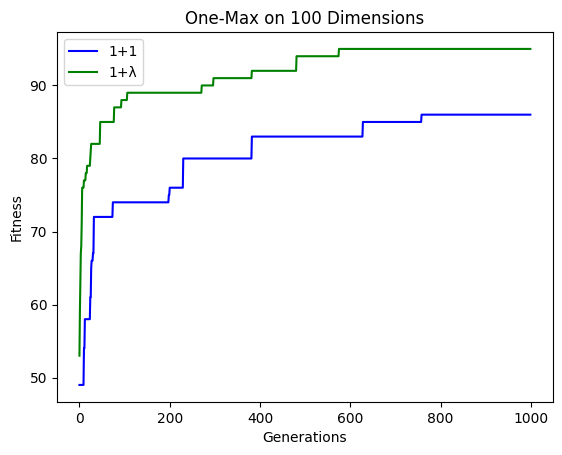

In [63]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(fits_𝜆, label="1+λ", color='g')
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

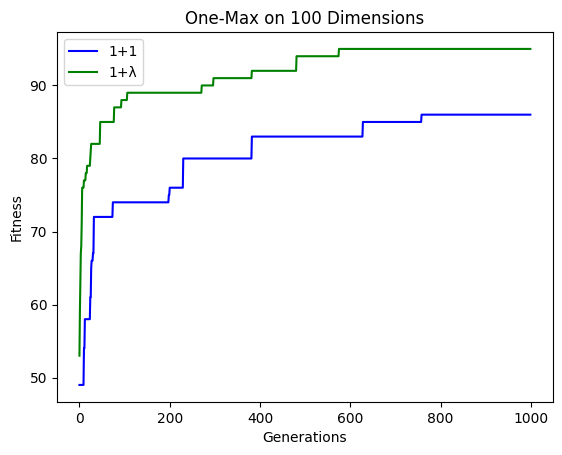

In [64]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(fits_𝜆, label="1+λ", color='g')
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

* (1+λ)-EA seems to be better than (1+1)-EA. But is this a fair comparison?

* (1+λ)-EA actually runs λ evaluation functions per generation, while (1+1)-EA only runs 1 evaluation function per generation.
* We need to plot the results base on the number of evaluations.

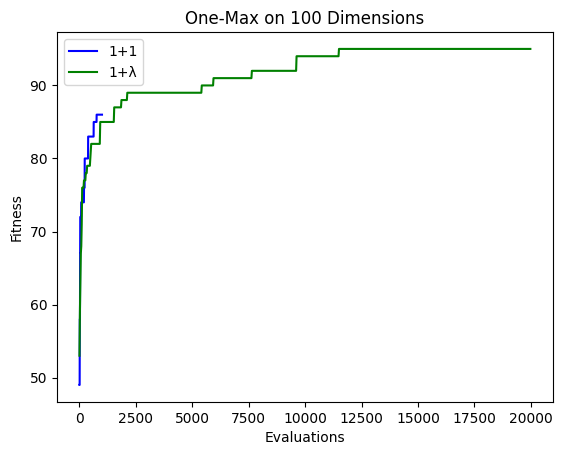

In [65]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(np.arange(1,n_gens*𝜆,𝜆), fits_𝜆, label="1+λ", color='g')
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

* We should give each algorithm the same number of function evaluations, like this:

In [66]:
n = 1000
n_gens = 10000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆)

100%|██████████| 500/500 [00:03<00:00, 126.51it/s]


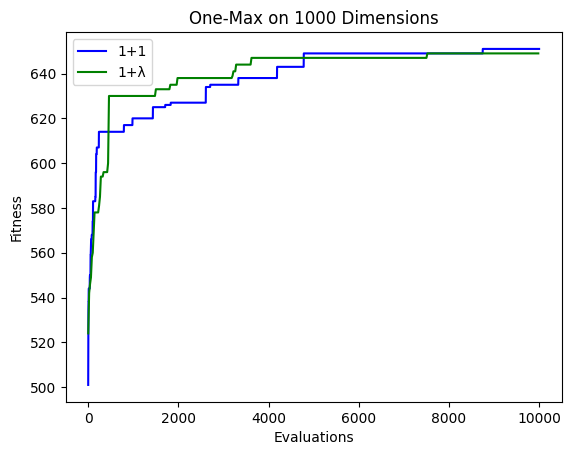

In [67]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(np.arange(1,n_gens,𝜆), fits_𝜆, label="1+λ", color='g')
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

* Because EAs employ randomness in their operations, to assess the performance of EAs, we should run them multiple times.
* Let's run each algorithm 10 independent times.

In [68]:
n_trials = 10
n = 100
n_gens = 1000

fits_1 = np.zeros((n_gens, n_trials))
fits_𝜆 = np.zeros((int(n_gens/𝜆), n_trials))

for i in range(n_trials):
    fits_1[:, i] = one_plus_one(n, n_gens, onemax)
    fits_𝜆[:, i] = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆)

100%|██████████| 50/50 [00:00<00:00, 788.64it/s]


In [69]:
μ_1 = np.mean(fits_1, axis=1)
σ_1 = np.std(fits_1, axis=1)
μ_𝜆 = np.mean(fits_𝜆, axis=1)
σ_𝜆 = np.std(fits_𝜆, axis=1)
print(np.shape(μ_1), np.shape(σ_1))
print(np.shape(μ_𝜆), np.shape(σ_𝜆))

(1000,) (1000,)
(50,) (50,)


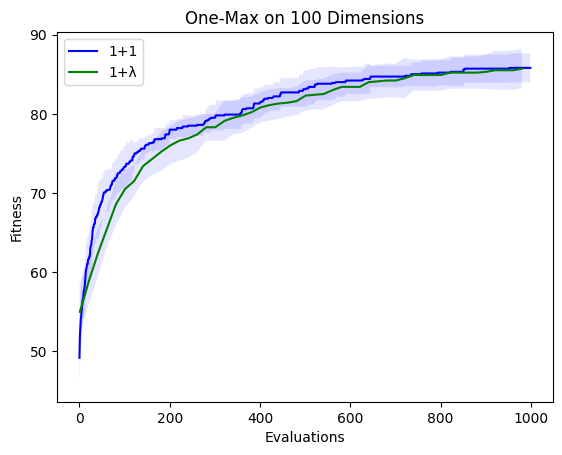

In [70]:
plt.plot(μ_1, label="1+1", color='b')
plt.fill_between(np.arange(0, n_gens), μ_1+σ_1, μ_1-σ_1, facecolor='b', alpha=0.1)
plt.plot(np.arange(1,n_gens,𝜆), μ_𝜆, label="1+λ", color='g')
plt.fill_between(np.arange(0, n_gens, 𝜆), μ_𝜆+σ_𝜆, μ_𝜆-σ_𝜆, facecolor='b', alpha=0.1)
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

**Question:** Compare the (1+1)-EA and (1+λ)-EA on the Leading Ones problem.

* **Deceptive function** (or **Trap** function) is another benchmark function for EA.
* A trap-$k$ function is defined as follows.

\begin{equation*}
\text{trap}_k(u)=
\begin{cases}
k & \text{if} \quad u = k \\
k - 1 -u & \text{if} \quad u < k
\end{cases}
\end{equation*}

![trap-4.png](attachment:trap-4.png)

* We usually concatenate multiple $k$-bit trap functions to create the **Concatenated $k$-bit trap function**.

In [71]:
def trap_4_bit(num_ones):
    if num_ones == 4:
        return 4
    return 4 - 1 - num_ones

def concatenated_trap_4(ind: Individual):
    f = 0
    num_ones = 0
    for i in range(0,len(ind.genes),4):
        num_ones = sum(ind.genes[i:i+4])
        f = f + trap_4_bit(num_ones)

    return f
ind = Individual(12)
print(ind)
concatenated_trap_4(ind)

(Ind: [1 1 0 1 1 0 1 1 0 1 1 0], -inf)


np.int64(1)

In [72]:
n_trials = 10
n = 20
n_gens = 100000
λ = 100

fits_1 = np.zeros((n_gens, n_trials))
fits_𝜆 = np.zeros((int(n_gens/𝜆), n_trials))

for i in range(n_trials):
    fits_1[:, i] = one_plus_one(n, n_gens, concatenated_trap_4)
    fits_𝜆[:, i] = one_plus_lambda(n, int(n_gens/𝜆), concatenated_trap_4, 𝜆)

100%|██████████| 1000/1000 [00:03<00:00, 277.39it/s]


In [73]:
μ_1 = np.mean(fits_1, axis=1)
σ_1 = np.std(fits_1, axis=1)
μ_𝜆 = np.mean(fits_𝜆, axis=1)
σ_𝜆 = np.std(fits_𝜆, axis=1)
print(np.shape(μ_1), np.shape(σ_1))
print(np.shape(μ_𝜆), np.shape(σ_𝜆))

(100000,) (100000,)
(1000,) (1000,)


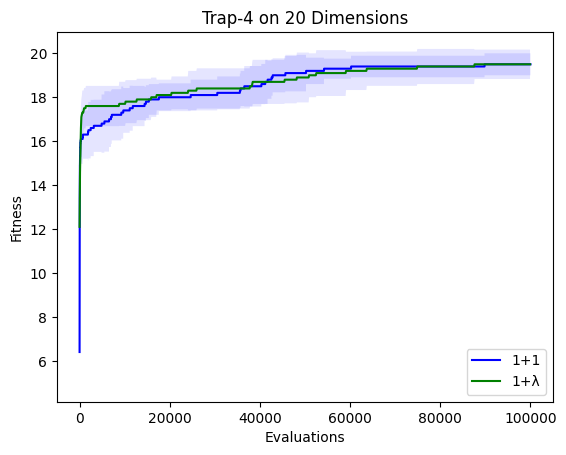

In [74]:
plt.plot(μ_1, label="1+1", color='b')
plt.fill_between(np.arange(0, n_gens), μ_1+σ_1, μ_1-σ_1, facecolor='b', alpha=0.1)
plt.plot(np.arange(1,n_gens,𝜆), μ_𝜆, label="1+λ", color='g')
plt.fill_between(np.arange(0, n_gens, 𝜆), μ_𝜆+σ_𝜆, μ_𝜆-σ_𝜆, facecolor='b', alpha=0.1)
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"Trap-4 on {n} Dimensions")
plt.legend();

# Algorithm control parameters

* In practice, the choice of mutation rate $p$ and population size λ greatly influence experimental results.
* We can also use **self-adjusting parameters**, which is similar to what simulated annealing uses.

https://link.springer.com/article/10.1007/s00453-018-0502-x

**Question**:

* Investigave the effect of population size λ and mutation rate $p$ on (1+1)-EA and (1+λ)-EA.
* Try implementing a dynamic mutation rate (e.g., a mutation rate that decreases over time) and compared it with the fixed mutation rate $p=\frac{1}{n}$.